# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [638]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [639]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [640]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [641]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [642]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [643]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [644]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

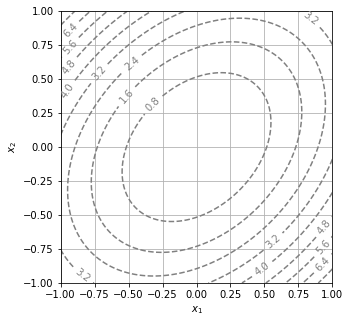

In [645]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [646]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

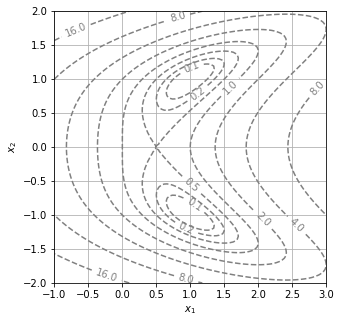

In [647]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [648]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

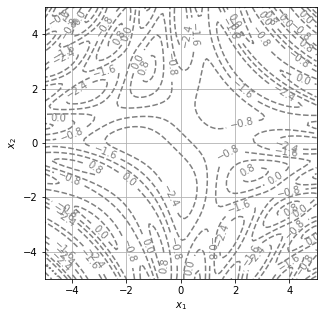

In [649]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [650]:
N = 100
eps = 10**(-3)

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

[3.8760056272722174, 3.8760056272722174]


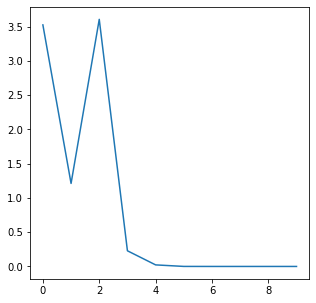

In [651]:
def Newton(F, x0, y0, eps=eps, N=N):
    i = 0
    distance = eps
    D = np.zeros(N) #matrice des distances successives
    v = np.array([x0, y0])
    while i<N and distance >= eps :
        x, y = v[0], v[1]
        JFv_inv = np.linalg.inv(J(F)(x, y))
        v = v - np.dot(JFv_inv,F(x, y))
        x, y = v[0], v[1]
        distance = np.sqrt((F(x, y)[0])**2+(F(x, y)[1])**2)  #la distance est supérieure à |x-y| et à |f(x,y)-c|
        D[i] = distance
        i = i + 1
    if i == N :
        raise ValueError(f"no convergence in {N} steps.")
    else :
        return [x, y, D]

def aux(f, c) : #renvoie la fonction F définie par F(x,y)=[f(x,y)-c,x-y]
    def F(x, y) :
        return np.array([f(x, y)-c, x-y])
    return F

res = Newton(aux(f3, 0.8), 0.8, 1.8, eps=eps, N=10)
print(res[0 : 2]) #le point final

T = np.arange(0,10)
D = res[2]
plt.plot(T, D)
plt.show()

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

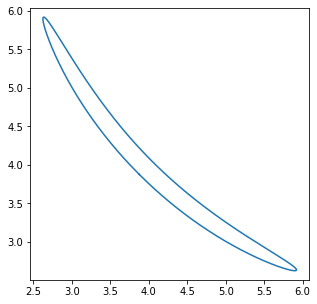

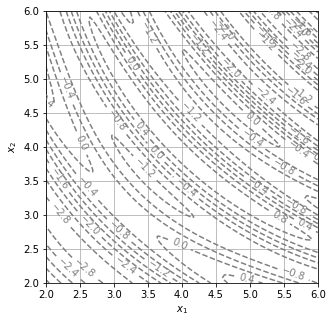

In [652]:
def distance(u, v) : #distance euclidienne entre les points u et v
   return np.sqrt( (u[0]-v[0])**2 + (u[1]-v[1])**2 ) 

def aux2(f,c,ancien_point,delta) : #renvoie la fonction F définie par F(x,y)=[f(x,y)-c,...]
      def F(x, y) : #la condition sera d'être à une distance delta du point précédent
         return np.array([f(x, y) - c, distance(ancien_point, [x, y]) - delta]) 
      return F

def level_curve(f, c, x0, y0, delta, N=1000, eps=eps) :
   def point_suivant(f, c, ancien_point) :
      x0, y0 = ancien_point[0], ancien_point[1]
      gradient = grad(f)(x0, y0)
      norme_gradient = np.sqrt(gradient[0]**2 + gradient[1]**2)
      v = [delta*gradient[1]/norme_gradient, -delta*gradient[0]/norme_gradient] #vecteur orthogonal "à droite" de grad(f)(x,y) de norme delta
      x, y = x0 + v[0], y0 + v[1] #translation du point (x,y) de v
      F = aux2(f, c, ancien_point, delta)
      return Newton(F, x, y, eps, N)[0:2] #fournit un point [x,y] tel que f(x,y)=c à eps près et [x,y] est situé à une distance delta de l'ancien point à eps près
   P = np.empty((N, 2))
   F = aux(f ,c)
   P[0] = Newton(F, x0, y0, eps=eps, N=N)[0 : 2]
   P[1] = point_suivant(f, c, P[0])
   P[2] = point_suivant(f, c, P[1]) #on construit les points 1 et 2 manuellement pour s'écarter du point 0 de plus de delta
   i = 3
   while i < N and distance(P[0],P[i-1]) > delta :
      P[i] = point_suivant(f,c,P[i-1])
      i += 1
   P[i] = P[0]
   return P[ : i+1]

P=level_curve(f3, 0.8, 0.8, 0.8, 0.01, 1000, eps)
plt.plot(P[:, 0], P[:, 1])
plt.axis('equal')
plt.show()

display_contour(
    f3, 
    x=np.linspace(2.0, 6.0, 100), 
    y=np.linspace(2.0, 6.0, 100), 
    levels=10 # 10 levels, automatically selected
)

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

Méthode des carrés : première estimation de l'aire :  3.127445957146613
Méthode des carrés : encadrement à 10^-2 près :  (3.139623951354205, 3.145280403849695)


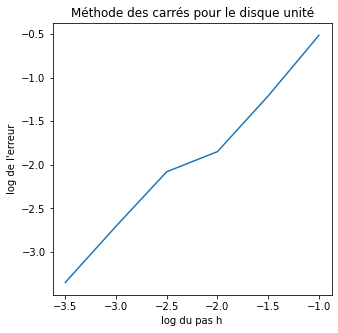

Méthode des triangles pour le disque unité : première estimation de l'aire à 10^-2 près : 1.1106694726394477


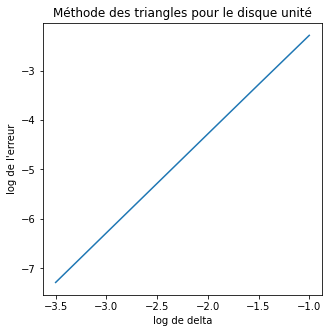

Le log de l'erreur semble proportionnel au log de delta.

Avantages et inconvénients des deux méthodes :
                                 Méthode des carrés          Méthode des triangles
Complexité C(t) :                   C(t)=O(1/h^2)               C(t)=O(1/delta) 
Erreur µ :                         log(µ)=O(log(h))          log(µ)=O(log(delta))    
µ en fonction de C(t) :            µ=O(C(t)^(-1/2))              µ=O(1/C(t)^2) 

La dernière ligne a été obtenue grâce à une observation graphique dans le cas du disque unité.
Elle montre l'avantage de la méthode des triangles sur celle des carrés.
En effet, avec la première, doubler la complexité divise l'erreur par 4.
Avec la méthode des carrés, l'erreur est seulement divisée par racine de 2.


In [653]:
#METHODE DES CARRES

def barycentre(P) : #barycentre d'une liste de points
    n = len(P)
    return np.sum(P, axis=0)/n

def f4(x, y) : #fonction disque unité
    return x**2 + y**2

def area_squares(f, c, x0, y0, delta, N, eps, h): #première version
    P = level_curve(f4, c, x0, y0, delta, N, eps)
    g = barycentre(P)
    L = []
    for p in P :
        L.append(distance(g, p))
    largeur = 2*max(L)
    n = int(largeur//h + 1)
    B_inf = np.empty((n,n),dtype='bool')
    x_g, y_g = g[0], g[1]
    fv = np.vectorize(f)
    for i in range(n) :
        B_inf[i,:] = fv(x_g + (i-n//2)*h, y_g + (np.arange(n)-n//2)*h) <= c
    return largeur**2*np.sum(B_inf)/n**2

#on conserve l'estimation de l'aire précédente comme estimation inférieure. Pour l'estimation supérieure, on prend en
#compte les cases "frontalières" du tableau B_inf en considérant que l'aire réelle les occupe en partie.
#Remarque : cette méthode ne fonctionne que pour les aires convexes.

def area_squares2(f, c, x0, y0, delta, N, eps, h): #estimations inférieure et supérieure de l'aire
    P = level_curve(f4, c, x0, y0, delta, N, eps)
    g = barycentre(P)
    L = []
    for p in P :
        L.append(distance(g, p))
    largeur = 2*max(L)
    n = int(largeur//h + 1)
    B_inf = np.empty((n,n),dtype='bool')
    x_g, y_g = g[0], g[1]
    fv = np.vectorize(f)
    for i in range(n) :
        B_inf[i,:] = fv(x_g + (i-n//2)*h, y_g + (np.arange(n)-n//2)*h) <= c
    B_sup = np.empty((n,n),dtype='bool')
    for i in range(n):
        for j in range(n): #ajout des cases à la frontière du tableau B_inf précédent
            if B_inf[i,j] or (i>1 and B_inf[i-1,j]) or (i<n-1 and B_inf[i+1,j]) or (j>1 and B_inf[i,j-1]) or (j<n-1 and B_inf[i,j+1]):
                B_sup[i,j]=True
            else:
                B_sup[i,j]=False
    return largeur**2*np.sum(B_inf)/n**2, largeur**2*np.sum(B_sup)/n**2


def encadrement(f, c, x0, y0, delta, N, eps, precision): #fournit un encadrement à precision près de l'aire
    h=10**(-1)
    aire_inf,aire_sup = area_squares2(f, c, x0, y0, delta, N, eps, h)
    while aire_sup-aire_inf>precision:
        h=h/10
        aire_inf,aire_sup = area_squares2(f, c, x0, y0, delta, N, eps, h)
    return aire_inf, aire_sup

print("Méthode des carrés : première estimation de l'aire : ",
area_squares(f4, 1, 1., 1., 0.01, 1000, eps, 10**(-2)))
print("Méthode des carrés : encadrement à 10^-2 près : ",encadrement(f4, 1, 1., 1., 0.01, 1000, eps, 10**(-2)))

H = 1/10**(np.arange(1, 4, 1/2))
Area_squares = np.vectorize(area_squares)
Difference = np.abs(np.pi-Area_squares(f4, 1, 1., 1., 0.01, 1000, eps, H))
plt.plot(np.log10(H), np.log10(Difference))
plt.title("Méthode des carrés pour le disque unité")
plt.xlabel("log du pas h")
plt.ylabel("log de l'erreur")
plt.show()

#METHODE DES TRIANGLES

def aire_triangle(point1, point2, point3) : #calcul de l'aire grâce à la formule de Héron
    d1, d2, d3 = distance(point1, point2), distance(point2, point3), distance(point3, point1)
    demi_perimetre = (d1 + d2 + d3)/2
    return np.sqrt(demi_perimetre*(demi_perimetre-d1)*(demi_perimetre-d2)*(demi_perimetre-d3))

def area_triangles(P): #P est la liste des points (x_i, y_i)
    g = barycentre(P)
    aire = 0
    n = len(P)
    for i in range(n-1):
        aire=aire + aire_triangle(g, P[i], P[i+1])
    aire=aire + aire_triangle(g, P[n-1], P[0])
    return aire

P = level_curve(f1, 1, 1., 1., 10**(-2), 10000, eps)
print("Méthode des triangles pour le disque unité : première estimation de l'aire à 10^-2 près :",  area_triangles(P))

borne = 4
Delta = 1/10**(np.arange(1, borne, 1/2))
Difference = np.empty(2*(borne-1))
for i in range(2*(borne-1)) :
    P = level_curve(f4, 1, 1., 1., Delta[i], 10**5, eps)
    Difference[i] = np.abs(np.pi - area_triangles(P))
plt.plot(np.log10(Delta), np.log10(Difference))
plt.title("Méthode des triangles pour le disque unité")
plt.xlabel("log de delta")
plt.ylabel("log de l'erreur")
plt.show()
print("Le log de l'erreur semble proportionnel au log de delta.")
print("")
print("Avantages et inconvénients des deux méthodes :")
print("                                 Méthode des carrés          Méthode des triangles")
print("Complexité C(t) :                   C(t)=O(1/h^2)               C(t)=O(1/delta) " )
print("Erreur µ :                         log(µ)=O(log(h))          log(µ)=O(log(delta))    ")
print("µ en fonction de C(t) :            µ=O(C(t)^(-1/2))              µ=O(1/C(t)^2) ")
print("")
print("La dernière ligne a été obtenue grâce à une observation graphique dans le cas du disque unité.")
print("Elle montre l'avantage de la méthode des triangles sur celle des carrés.")
print("En effet, avec la première, doubler la complexité divise l'erreur par 4.")
print("Avec la méthode des carrés, l'erreur est seulement divisée par racine de 2.")